In [1]:
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)

In [2]:
import os
import rpy2
import logging
import warnings
import anndata2ri
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import decoupler as dc
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from itertools import chain
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from functions import helper_functions


In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

-----
anndata     0.11.1
scanpy      1.9.3
-----
PIL                         9.5.0
anndata2ri                  1.1
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
decoupler                   1.4.0
dot_parser                  NA
exceptiongroup              1.1.1
executing                   1.2.0
functions                   NA
google                      NA
gsva_prep                   NA
h5py                        3.9.0
igraph                      0.10.4
ipykernel                   6.23.2
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
leidenalg                   0.9.1
llvmlite                    0.39.1
louvain      

In [4]:
%%R

suppressPackageStartupMessages({
    library(Matrix)
    library(viridis)
    library(harmony)
    library(ggpubr)
    library(tictoc)
    library(RColorBrewer)
    library(Hmisc)
    library(corrplot)
    library(grid)
    library(gridExtra)
    library(igraph)
    library(ggrepel)
    library(readxl)
    library(conflicted)
    library(dplyr)
    library(parallel)
    library(stringr)
    library(tibble)
    library(BiocParallel)

    # single-cell analysis package
    library(Seurat)
    library(zellkonverter)   
    library(SingleCellExperiment)
    library(tidyr)
    library(readxl)
    library(GSA)
    library(limma)

    # plotting and data science packages
    library(tidyverse)
    library(cowplot)
    library(patchwork)
    library(ggplot2)

    # co-expression network analysis packages:
    library(WGCNA)
    library(hdWGCNA)

    # gene enrichment packages
    library(enrichR)
    library(GeneOverlap)
    library(GSEABase)
    library(GSVA) 

    # cell-cell communication
    library(nichenetr)

# needs to be run every time you start R and want to use %>%
})

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
enableWGCNAThreads(nThreads = 40)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    Allowing parallel execution with up to 40 working processes.


In addition: There were 11 warnings (use warnings() to see them)


# **Systematic differential analysis of pathway activity**

Pathway activity scores were computed in accordance with the overall protocol outlined in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w).

- Aggregate gene expression profiles into `pseudo-cells` or `pseudo-bulks` depending on the desired strategy in **[Gazestani. et. al. 2023](https://www.sciencedirect.com/science/article/pii/S0092867423008590?via%3Dihub)** (`pseudo-cells`), [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w) (`pseudo-bulks`), or [**Morabito et al.**](https://www.sciencedirect.com/science/article/pii/S2667237523001273?via%3Dihub) (`meta-cells`)
 

- Use `PAGODA2`, `GSVA`, or `AUCell`, to obtain pathway activity scores for pathways (`GO Ontology Biological Processes`) obtained from [**Maayan Lab**](https://maayanlab.cloud/Enrichr/#libraries), [**MSigDB**](https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp#C5) or custom gene sets.

- Perform differential pathway activity analysis using limma

## **Data Prep Parameters**

- `test_names`: List of the different test names of interest.

- `save_prefix`: Preferred prefix for saving critical files. Ideally chosen to be in the format `{source name}_{brain region}`. e.g `mathys_pfc`

- `subject_id`: Column name for Subject/Patient ID in both metadata and `.obs`

In [5]:
save_prefix = 'seaad_mtg'                                       # this takes the format '{StudyName}_{ThreeLetterAccronymForBrainRegion}'
subject_id = helper_functions.clean_strings('Donor ID')
cell_type_column = 'Subclass'                                   # 'Supertype (non-expanded)', 'Subclass'
factor = 'Continuous Pseudo-progression Score'    # pathology.group # Continuous Pseudoprogression Score
factor = helper_functions.clean_strings(factor, replace_hyphen=True)
test_names = ['late_vs_early']                                  # test categories
region_name = save_prefix.split('_')[-1].upper()
count_agg_strategy = 'metacell'   # options 'network', 'random', 'pseudobulk', 'smaller_network', 'standardbulk', 'metacell', `blanchardbulk``


data_dir = f'/media/tadeoye/Volume1/data/seq/SEA-AD/{region_name}/RNAseq/'
save_dir = f'../results/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

subclass = {
    'excitatory': ['L5 IT', 'L2/3 IT', 'L4 IT', 'L6 IT', 'L6 IT Car3', 'L5/6 NP', 'L6b', 'L6 CT', 'L5 ET'],
    'inhibitory': ['Pvalb', 'Sst', 'Lamp5 Lhx6', 'Vip', 'Lamp5', 'Sncg', 'Chandelier', 'Sst Chodl', 'Pax6'],
    'astrocyte': ['Astrocyte'],
    'microglia': ['Microglia-PVM'],
    'opc': ['OPC'],
    'oligodendrocyte': ['Oligodendrocyte'],
    'endothelial': ['Endothelial'],
    'vlmc': ['VLMC'],
    }

cell_supertypes = list(chain(*list(subclass.values())))
Subclass = robjects.ListVector(subclass)


# **Load Merged Pseudo-bulked Data**

We have merged the pseduobulked data for all cell sypertypes (`02_merge_pseudobulks.ipynb`). Now, we load the merged data.

In [6]:
clean_subclass = robjects.ListVector({k: [helper_functions.clean_strings(v, preserve_case=True) for v in val] for k, val in subclass.items()})
clean_cell_supertypes = [helper_functions.clean_strings(cell_type, preserve_case=True) for cell_type in cell_supertypes]

In [7]:
adata_merged = sc.read_h5ad(data_dir+f'counts/anndata/all_subclass_{count_agg_strategy}_anndata.h5ad')

adata_annot = sc.read_h5ad(os.path.join(data_dir, f'counts/anndata/{save_prefix.upper()}_RNAseq_final-nuclei.2024-02-13.h5ad'))
adata_annot.X = adata_annot.layers['UMIs'] 

In [8]:
%%R -i adata_merged -i count_agg_strategy -i data_dir -i subject_id -i Subclass -i cell_supertypes -i clean_cell_supertypes -i clean_subclass

source('../scripts/functions/helper_functions.r')

print('Merged data loaded')
adata_merged

[1] "Merged data loaded"
class: SingleCellExperiment 
dim: 36601 111258 
metadata(0):
assays(2): X logcounts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(111258): L5 IT_1#H19.33.004_1 L5 IT_1#H19.33.004_2 ...
  VLMC_1#H21.33.027_5 VLMC_1#H21.33.027_6
colData names(21): donor_id orig.ident ... pseudo_genes_detected
  pseudo_number_of_umis
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/home/tadeoye/R/x86_64-pc-linux-gnu-library/4.5’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/home/tadeoye/R/x86_64-pc-linux-gnu-library/4.5’ contains no packages


In [9]:
# del adata_merged, summed_counts_per_celltype

# **Pathway Database**

First, we load pre-defined pathway annotations from established databases and then filter these databases for expressed genes.

In [10]:
database_dir = data_dir.replace(f"/seq/SEA-AD/{region_name}/RNAseq/", "/pathway_databases")

### **Curated Gene Sets Obtained From [Galea et al. 2022](https://doi.org/10.1016/j.nbd.2022.105655)**

In [11]:
galea_curated = pd.read_excel(f'{database_dir}/galea_2022_curated_gene_sets/gene_sets.xlsx')
galea_curated['Gene set'] = galea_curated['Functional categories'] + ': ' + galea_curated['Functional subcategories']
galea_curated.rename(columns={'Gene symbol': 'Gene'}, inplace=True)
gl_gmt = helper_functions.save_curated_as_gmt(galea_curated, name_col='Gene set', member_col='Gene', 
                                              tempdir=f'{database_dir}/galea_2022_curated_gene_sets/')
gl_gmt_path = f'{database_dir}/galea_2022_curated_gene_sets/gs.gmt'

### **Curated Gene Sets Obtained From [Gabitto et al. 2022](https://doi.org/10.1101/2023.05.08.539485)**

In [12]:
gabitto_curated = pd.read_excel(f'{database_dir}/gabitto_2023_curated_gene_sets/gene_sets.xlsx')
gb_gmt = helper_functions.save_curated_as_gmt(gabitto_curated, name_col='Gene set', member_col='Gene', 
                                              tempdir=f'{database_dir}/gabitto_2023_curated_gene_sets/')
gb_gmt_path = f'{database_dir}/gabitto_2023_curated_gene_sets/gs.gmt'

### **Curated Synaptic Related Gene Sets Obtained From [Koopmans et al. 2019](https://www.sciencedirect.com/science/article/pii/S0896627319304271?via%3Dihub)**

In [13]:
syngo_curated = pd.read_excel(f'{database_dir}/SynGO_bulk_download_release_20231201/syngo_annotations.xlsx')
syngo_curated.rename(columns={'go_name': 'Gene set', 'hgnc_symbol': 'Gene'}, inplace=True)
syngo_gmt = helper_functions.save_curated_as_gmt(syngo_curated, name_col='Gene set', member_col='Gene', 
                                                 tempdir=f'{database_dir}/SynGO_bulk_download_release_20231201/')
syngo_gmt_path = f'{database_dir}/SynGO_bulk_download_release_20231201/gs.gmt'

### **Curated Gene Sets Obtained From Human Molecular Signatures Database ([MSigDB](https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp#C5))**
- **[Reactome](https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=CP:REACTOME)**
- **[KEGG](https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=CP:KEGG_LEGACY)**
- **[Gene Ontology: Biological Processes](https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=GO:BP)**
- **[TFT: transcription factor targets](https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=TFT)**

In [14]:
bp_gmt_path = f'{database_dir}/MSigDB/c5.go.bp.v2024.1.Hs.symbols.gmt'                  # CP: Canonical pathways BP: subset of GO
ke_gmt_path = f'{database_dir}/MSigDB/c2.cp.kegg_legacy.v2024.1.Hs.symbols.gmt'         # CP: Canonical pathwaysKEGG_LEGACY subset of CP
re_gmt_path = f'{database_dir}/MSigDB/c2.cp.reactome.v2024.1.Hs.symbols.gmt'            # CP: Canonical pathways Reactome subset of CP
tft_gtrd_gmt_path = f'{database_dir}/MSigDB/c3.tft.gtrd.v2024.1.Hs.symbols.gmt'         # TFT: transcription factor targets: GTRD subset of TFT
tft_legc_gmt_path = f'{database_dir}/MSigDB/c3.tft.tft_legacy.v2024.1.Hs.symbols.gmt'   # TFT: transcription factor targets: TFT_LEGACY subset of TFT

# **Pathway Activity Scoring**

We now implement the pathway activity soring pipeline employed by **[Yaru Zhang et al. 2020](https://www.sciencedirect.com/science/article/pii/S2001037020304293#s0135)**. 

Briefly, **[Zhang et al](https://www.sciencedirect.com/science/article/pii/S2001037020304293#s0135)** performed a systematic benchmarking study to evaluate the performance of unsupervised pathway activity score(`PAS`) transformation algorithms. Essentially, PAS algorithms tranform the gene-level data into explainable gene sets representing biological processes or pathways to uncover the potential mechanism of cell heterogeneity. 

The tools benchmarked in the study include : 

> *Please hover over each method name to view full description*

- [`AUCell`](https://www.nature.com/articles/nmeth.4463 "AUCell is a rank-based enrichment analysis method for quantifying gene set activity in single-cell transcriptomics data. The algorithm employs a recovery-based scoring approach that first ranks genes according to their expression magnitude within individual cells. Subsequently, it computes an area under the recovery curve (AUC) by assessing the fraction of gene set members among the top-ranked genes, thereby generating cell-specific enrichment scores that represent the PAS"): Area under the ranked gene expression curve.

- [`Vision`](https://doi.org/10.1038/s41467-019-12235-0 "Vision is an annotation toolkit that uses autocorrelation statistics to identify biological variations across cells. Vision starts to identify closest K-nearest neighbors of each cell for generating a cell–cell K-nearest-neighbor (KNN) graph. PASs in Vision are calculated by averaging expressed genes for each gene set. To account for the influence of sample-level metrics (the number of UMIs/reads per cells), PASs are then corrected by their means and standard deviations. Expression data used in Vision could be scaled and normalized, but not log-transformed."): Summarizing the normalized expression of genes in the gene sets.

- [`Pagoda2`](https://doi.org/10.1038/nbt.4038.Integrative "Pathway and gene set overdispersion analysis (Pagoda2) implements a pathway overdispersion analysis method for single-cell data. It first evaluates the variance of individual genes, taking into account technical factors. It then identifies pathways showing coordinated variability by combining the variance patterns of pathway genes using weighted PCA, while controlling for technical aspects and adjusting for multiple hypothesis testing."): First principal component of gene sets

- [`GSVA`](https://doi.org/10.1186/1471-2105-14-7 "GSVA implements a non-parametric, unsupervised method for estimating variation in pathway activity across samples. It first estimates a normalized relative expression level per gene across samples. This expression level is then rank-ordered for each sample and aggregated into gene sets by calculating sample-wise enrichment scores using a Kolmogorov–Smirnov-like rank statistic."): Kolmogorov-Smirnov-like rank statistic based on kernel estimation of th cumulative density.

- [`ssGSEA`](https://doi.org/10.1038/nature08460.Systematic "Briefly, ssGSEA implements a rank-based method to generate an enrichment score per sample per gene set. It first ranks all genes by their expression value for each sample. Then, for each gene set, it calculates an enrichment score that represents the degree of absolute enrichment of that gene set in each sample based on the integration of the differences between empirical cumulative distribution functions of gene expression ranks."): Kolmogorov-Smirnov-like rank statistic based on gene expression of single sample. 

- [`Combined z-score`](https://doi.org/10.1371/journal.pcbi.1000217 "This method implements a parametric method for pathway activity estimation. It first standardizes gene expression values across samples to generate z-scores for each gene. These gene-level z-scores are then aggregated for each pathway by calculating their mean or sum, producing a pathway-level score that represents the overall activation state of the pathway in each sample."): Combinzed z-score.

## **Method Selection for PAS**

**[Zhang et al.](https://www.sciencedirect.com/science/article/pii/S2001037020304293#s0135)** identified `Pagoda2` and `Vision` as the highest performing methods for pathway activity scoring, likely due to their direct estimation of pathway activity scores (PAS) from the expression data.

<figure align="center">
   <img src="../docs/pas_performance_summary.jpg" alt="Pathway Activity Score Performance Summary" width="30%">
   <figcaption><b>Figure 1:</b> Comparative performance evaluation of pathway activity scoring methods across multiple metrics</figcaption>
</figure>

Based on these findings, our analysis focuses on the three top-performing methods `Pagoda2`, `Vision`, and `AUCell`, inlcuding `GSVA` following our previous work ([**Adeoye et al. 2024**](https://www.aginganddisease.org/EN/10.14336/AD.2024.0429)). However, we here elect to use only `AUCell` as the other listed methods do not scale well with such large data.

> **Note**: Users preferring GSVA can still efficiently apply it by first setting `count_agg_strategy = pseudobulk` in `01_pseudobulking.ipynb` to use standard pseudobulking instead of metacells. But we doubt this will yield reliable results.

The authors provide the [PASBench](https://github.com/sulab-wmu/PASBench/tree/master) package that contain the seven PAS tools and evaluation metrics.

## **Parameter Selection for [PASBench](https://github.com/sulab-wmu/PASBench/tree/master)**

The following parameters control the calculation of pathway activity scores from single-cell gene expression data:

#### **Core Parameters**
- `counts`: the pseudobulked SingleCellEXperiment object. Values must contain expression `counts` assay/layer.

- `gmt_file`: Path to GMT format file containing pathway definitions.

- `species`: Species designation for pathway analysis. Options: `"human"` or `"mouse"`.

- `pathway`: Abbreviated name of pathway database (e.g., `KEGG`, `GO`, `REACTOME`). Only called when gmt_file is `none`

- `tool`: Specifies the analysis method to use. In this case, any of `Pagoda2` or `AUCell`
 > *See [method descriptions above](#) for details on each tool*

- `filter`: Controls expression-based gene filtering. When `TRUE`, removes genes expressed in <5% of cells. When `FALSE`, retains all genes. We already filtered genes before pseudobulking, so this **[Zhang et al.](https://www.sciencedirect.com/science/article/pii/S2001037020304293#s0135)** will be set to `FALSE`

- `normalize`: Specifies data normalization method. This is required to make expression values comparable across cells. The specified method should be appropriate for chosen tool. Options are `log`,`CLR`(Centered Log Ratio in Seurat),`RC` (Relative Counts in Seurat),`scran`,`scTransform`,`none`.

The figure below shows the distribution of averaged performance score across normalization strategies from **[Zhang et al.](https://www.sciencedirect.com/science/article/pii/S2001037020304293#s0135)**. 

<figure align="center">
   <img src="../docs/performance_by_normalization_strategy.jpg" alt="Averaged Performance Score Across Filtering and Normalization Strategies" width="50%">
   <figcaption><b>Figure 2:</b> Comparative performance evaluation of pathway activity scoring methods across filtering and normalization strategies</figcaption>
</figure>

This figure shows that:

- `Pagoda2` and `Vision` display the same performance irrespective of the chosen normalization method. Hence, we perform no normalization

- perfomance of `AUCell` depends on the normalization strategy. So, we choose [scTransform](https://github.com/satijalab/sctransform) normalization, since the other tools all display better performance with this method.

- For `GSVA`, we recommend setting the the normalization method to none, as the default `assay` chosen from the `SingleCellExperiment` object is `logcount` appropriate for the `Gaussian` kernel applied to `log CPM` data. User can likewise change parameters like `maxDiff`, `min/max_set_size`, and `kcdf`. 

In [15]:
pas_methods = ['GSVA']
normalization_methods = robjects.ListVector({'AUCell': 'none', 'pagoda2': 'none', 'GSVA': 'none'})
assay_name = 'logcounts'    # assay name in pseudobulked singlecellexperiment object. 
                            # If set to `logcounts` then `kcdf` must be set to `Gaussian` and normalization method must be 'none'
kcdf = 'Gaussian'           # determines the kernel density used to model gene expression across samples
max_set_size = 150          # Upper bound of gene set size
min_set_size = 5            # lower bound of gene set size
maxDiff = 'TRUE'            # Controls how enrichment score is calculated from the Kolmogorov-Smirnov random walk statistics
                            # controls which curated gene set database the statistic is estimated for
n_cores = 40
normalize_AUCell = 'FALSE'

curated_gene_set_db = robjects.ListVector({
    'gabitto': gb_gmt_path,
    'galea': gl_gmt_path,
    'syngo': syngo_gmt_path,
    'gobp': bp_gmt_path,
    'reactome': re_gmt_path,
    'kegg': ke_gmt_path, 
    'gtrd': tft_gtrd_gmt_path,
    'tft': tft_legc_gmt_path,
    })       

In [16]:
covariates = [
    'Continuous Pseudo-progression Score',
    'Age at Death binned codes',
    'Sex',
    'APOE4_Status',
    'Pseudo Genes Detected',
    'Pseudo Number of UMIs',
    # 'PMI',
    'method',
    'Race (choice=White)',
]

covariates = helper_functions.clean_strings(covariates)

#### **Output Structure**
The implemented algorithms generates two complementary data structures:

1. A dictionary containing pathway activity scores for each gene set and method defined in `curated_gene_set_db`
2. A SingleCellExperiment object encoding a matrix of pathway activity scores (PAS) across cell types, where:
   - Rows represent individual pathways
   - Columns represent distinct cell types
   - Matrix elements contain non-/normalized PAS

The SingleCellExperiment object maintains the relationship between PAS and cellular identities while preserving the original experimental design structure. This allows us to perform downstream analysis on activuty scores like clustering and visualizing PAS in cellular populations.

In [ ]:
%%R -i cell_type_column -i normalize_AUCell -i max_set_size -i min_set_size -i kcdf -i maxDiff -i assay_name -i curated_gene_set_db -i pas_methods -i n_cores -i normalization_methods -o pas_scores -o pas_object

source('../scripts/functions/PASBench/R/main.R')
source('../scripts/functions/helper_functions.r')


pas_scores = list()
pas_object = list()
gene_sets <- curated_gene_set_db

for (gs in names(gene_sets)){
    pas_scores[[gs]] <- list()
    pas_object[[gs]] <- list()

    all_gs_genes <- unique(unlist(read.geneset(gene_sets[[gs]])))
    current_genes <- rownames(adata_merged)
    genes_to_keep <- current_genes %in% all_gs_genes

    for (method in pas_methods){
        
        if (method == 'GSVA'){
            sce <- assay(adata_merged[genes_to_keep, ], assay_name)
        }else{
            sce <- assay(adata_merged[genes_to_keep, ], 'X')
        }

        # run PAS scoring
        print(paste0("Estimating Activity Scores of ", gs, " Pathways using ", method, " scoring method"))
        print("........")

        res <- calculate_PAS(
            sce,
            method,                         # tool name
            species = 'none',               # species; human or mouse
            pathway = 'none',               # abbreviation for pathway database
            gmt_file = gene_sets[[gs]],     # pathways in GMT format
            filter = F,                     # whether filtering for genes expressed in less than 5 percent cells
            gsvaPar = list(                 # Parameters for when method selected is GSVA
                maxDiff = as.logical(maxDiff), 
                kcdf = kcdf, 
                minSize = min_set_size, 
                maxSize = max_set_size
                ),
            AUCellpar = list(normAUC=as.logical(normalize_AUCell)),
            normalize = normalization_methods[[method]],
            n_cores = n_cores,
            rand_seed = 12345
        )

        pas_scores[[gs]][[method]] <- as.data.frame(res)
        pas_object[[gs]][[method]] <- as.SingleCellExperiment(prepare_vis(pas_scores[[gs]][[method]]))

        colData(pas_object[[gs]][[method]]) <- DataFrame(
                merge(as.data.frame(colData(pas_object[[gs]][[method]])), 
                    as.data.frame(colData(adata_merged)), 
                    by=0, 
                    row.names=1)
        )
        rownames(colData(pas_object[[gs]][[method]])) <- colData(pas_object[[gs]][[method]])$Row.names   
    }
}

[1] "Estimating Activity Scores of gabitto Pathways using GSVA scoring method"
[1] "........"
Do not filter genes.
[1] "normalize error"
Setting parallel calculations through a MulticoreParam back-end with workers=40 and tasks=100.
Estimating GSVA scores for 76 gene sets.
Estimating ECDFs with Gaussian kernels
  |===========================================================           |  84%

#### **Save Pathway Activity Scores**

In [39]:
%%R

if (!dir.exists(paste0(data_dir, "results/PAS/"))) {
  dir.create(paste0(data_dir, "results/PAS/"))
}

saveRDS(pas_object, paste0(data_dir, "results/PAS/", "all_PAS.rds"))

In [41]:
for gs in curated_gene_set_db.names:
    for method in pas_methods:
        pas_object[gs][method].write_h5ad(os.path.join(data_dir,  "results", "PAS", f"{gs}_geneset_{method}_PAS.h5ad"),
                              compression='gzip')

In [ ]:
%%R -i cell_type_column -i normalize_AUCell -i max_set_size -i min_set_size -i kcdf -i maxDiff -i assay_name -i curated_gene_set_db -i pas_methods -i n_cores -i normalization_methods


library(gsdensity)
library(ggplot2) # for plotting
library(reshape2)
library(msigdbr) # for gathering gene sets
library(Seurat)
library(SeuratData)
# library(future) # for parallel computing
# library(future.apply) # for parallel computing

# use GO_BP gene sets 
# Conver the format to 'list'

mdb_c5 <- msigdbr(species = "Homo sapiens", category = "C5")
mdb_c5_bp <- mdb_c5[mdb_c5$gs_subcat == "GO:BP", ]
gene.set.list <- list()
for (gene.set.name in unique(mdb_c5_bp$gs_name)){
        gene.set.list[[gene.set.name]] <- mdb_c5_bp[mdb_c5_bp$gs_name %in% gene.set.name, ]$gene_symbol
}

# from SeuratData
data("pbmc3k")
# Normalize the data
pbmc3k <- NormalizeData(pbmc3k)

# compute cell/gene embeddings
ce <- compute.mca(object = pbmc3k)
# find gene sets with differential density 
res <- compute.kld(coembed = ce, 
                   genes.use = intersect(rownames(ce), rownames(pbmc3k)), # this intersection is to select only genes, not cells. 
                   n.grids = 100, 
                   gene.set.list = gene.set.list,
                   gene.set.cutoff = 3,
                   n.times = 100)                   
gene.set.deviated <- res[res$p.adj < 0.05, ]$gene.set

# # build nearest neighbor graph
# cells <- colnames(pbmc3k)
# el <- compute.nn.edges(coembed = ce, nn.use = 300)

# # get label propagation probability for each cell of a gene set 'GOBP_B_CELL_ACTIVATION'
# cv <- run.rwr(el = el, gene_set = gene.set.list[["GOBP_B_CELL_ACTIVATION"]], cells = cells)
# # get a 'positive' or 'negative' label for each cell of this gene set
# cl <- compute.cell.label(cv)

# # Compute the UMAP coordinates for visualization
# pbmc3k <- pbmc3k %>%
#         FindVariableFeatures() %>%
#         ScaleData() %>%
#         RunPCA() %>%
#         FindNeighbors() %>%
#         RunUMAP(dims = 1:20)
# # plot the cell annotation
# DimPlot(pbmc3k,
#         group.by = "seurat_annotations",
#         label = T,
#         raster = T)

Would you like to install 'msigdbdf'? 

1: Yes
2: No

Enter an item from the menu, or 0 to exit


* installing *source* package ‘msigdbdf’ ...
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (msigdbdf)


For full functionality, please install the 'msigdbdf' package with:
install.packages('msigdbdf', repos = 'https://igordot.r-universe.dev')
The 'msigdbdf' package must be installed to access the full dataset.
Installing the 'msigdbdf' package.
Installing package into ‘/home/tadeoye/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)
trying URL 'https://igordot.r-universe.dev/src/contrib/msigdbdf_24.1.0.tar.gz'
Content type 'application/gzip' length 12837035 bytes (12.2 MB)
downloaded 12.2 MB


The downloaded source packages are in
	‘/tmp/RtmpHGRxe2/downloaded_packages’
In addition: Warning messages:
1: replacing previous import ‘data.table::shift’ by ‘tictoc::shift’ when loading ‘CelliD’ 
2: The `category` argument of `msigdbr()` is deprecated as of msigdbr 10.0.0.
ℹ Please use the `collection` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


In [33]:
adata_merged

AnnData object with n_obs × n_vars = 111258 × 36601
    obs: 'donor_id', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cells_merged', 'Supertype', 'ident', 'method', 'Subclass', 'Supertype..non.expanded.', 'continuous_pseudo_progression_score', 'age_at_death_binned_codes', 'sex', 'race_choice_white', 'genes_detected', 'number_of_umis', 'pmi', 'apoe4_status', 'batch', 'pseudo_genes_detected', 'pseudo_number_of_umis'
    layers: 'logcounts'

In [17]:
%%R -i cell_type_column -i normalize_AUCell -i max_set_size -i min_set_size -i kcdf -i maxDiff -i assay_name -i curated_gene_set_db -i pas_methods -i n_cores -i normalization_methods

library(gsdensity)
library(ggplot2) # for plotting
library(reshape2)
library(msigdbr) # for gathering gene sets
library(Seurat)
library(SeuratData)
# library(future) # for parallel computing
# library(future.apply) # for parallel computing

# use GO_BP gene sets 
# Conver the format to 'list'


gene.set.list <- read.geneset(curated_gene_set_db[['gobp']])

# Normalize the data
sce <- adata_merged[, adata_merged$Subclass == 'Astrocyte']
adata <- as.Seurat(sce, counts='X')

adata[["RNA"]] <- adata[['originalexp']]
DefaultAssay(adata) <- "RNA"

adata <- NormalizeData(adata)

adata


An object of class Seurat 
73202 features across 4855 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: originalexp


Read 7608 records
Read 645524 items
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
In addition: Warning messages:
1: replacing previous import ‘data.table::shift’ by ‘tictoc::shift’ when loading ‘CelliD’ 
2: Key ‘originalexp_’ taken, using ‘rna_’ instead 


In [18]:
%%R

source('../scripts/functions/helper_functions.r')

conflicts_prefer(base::intersect)

# Add custom options for anticlustering before running compute.mca
options(anticlustering.solver = "ilp")  # "ilp" can handle unequal group sizes

# compute cell/gene embeddings
ce <- compute.mca(object = adata)
# find gene sets with differential density 
res <- compute.kld.fix(coembed = ce, 
                   genes.use = intersect(rownames(ce), rownames(adata)), # this intersection is to select only genes, not cells. 
                   n.grids = 100, 
                   gene.set.list = gene.set.list,
                   gene.set.cutoff = 3,
                   n.times = 100)                   
gene.set.deviated <- res[res$p.adj < 0.05, ]$gene.set


[conflicted] Will prefer base::intersect over any other package.
8.773 sec elapsed
271.878 sec elapsed
30.852 sec elapsed


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Computing Fuzzy Matrix
Computing SVD
Computing Coordinates
In addition: Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.3 GiB


In [19]:
%%R

# build nearest neighbor graph
cells <- colnames(adata)
el <- compute.nn.edges(coembed = ce, nn.use = 300)

# get label propagation probability for each cell of a gene set 'GOBP_B_CELL_ACTIVATION'
cv <- run.rwr(el = el, gene_set = gene.set.list[["GOBP_NEGATIVE_REGULATION_OF_SODIUM_ION_TRANSPORT"]], cells = cells)
# get a 'positive' or 'negative' label for each cell of this gene set
cl <- compute.cell.label(cv)


Runtime in total is: 4 secs

In addition: Warning message:
In locmodes(cell_vec, mod0 = 2) :
  If the density function has an unbounded support, artificial modes may have been created in the tails


In [28]:
%%R -o cv_results -o cl_results -o skipped_gene_sets

# get cell names
cells <- colnames(adata)

# compute nearest neighbor edges
el <- compute.nn.edges(coembed = ce, nn.use = 300)

# initialize empty data frames to store results
cv_results <- data.frame(row.names = cells)
cl_results <- data.frame(row.names = cells)


skipped_gene_sets <- c() # track skipped gene sets

# run for each gene set in gene.set.list
for (gene_set_name in names(gene.set.list)) {
  # get label propagation probability for each cell for current gene set
  tryCatch({
    cv <- run.rwr(el = el, 
                gene_set = gene.set.list[[gene_set_name]], 
                cells = cells)
    
    # get 'positive' or 'negative' label for each cell for current gene set
    cl <- compute.cell.label(cv)
    
    cv_results[[gene_set_name]] <- cv
    cl_results[[gene_set_name]] <- cl

  }, 
  error = function(e) {
    # check if it's the specific error
    if (grepl("No observations ", e$message)) {
      message(paste("SKIPPING gene set:", gene_set_name, "- Error:", e$message))
      skipped_gene_sets <- c(skipped_gene_sets, gene_set_name)
    } else {
      # For other errors, we might want to still see the full error
      stop(paste("Error in gene set:", gene_set_name, "-", e$message))
    }
  })
}

# report all skipped gene sets
if (length(skipped_gene_sets) > 0) {
  print("\nThere are", length(skipped_gene_sets), "skipped gene sets due to 'No observations' error:\n")
}

# cv_results contains propagation probabilities (cells x gene_sets)
# cl_results contains labels (cells x gene_sets)

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 3 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 9 secs

Runtime in total is: 4 secs

Runtime in total is: 3 secs

Runtime in total is: 3 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 3 secs

Runtime in total is: 4 secs

Runtime in total is: 8 secs

Runtime in total is: 3 secs

Runtime in total is: 3 secs

Runtime in total is: 3 secs

Runtime in total is: 5 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in total is: 4 secs

Runtime in tot

In [24]:
%%R -o cv_results -o cl_results


print('done')

[1] "done"


In [27]:
%%R

print(length(names(gene.set.list)))

[1] 7608


In [26]:
cl_results

,GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,GOBP_2FE_2S_CLUSTER_ASSEMBLY,GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS,GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS,GOBP_3_UTR_MEDIATED_MRNA_DESTABILIZATION,GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION,GOBP_4FE_4S_CLUSTER_ASSEMBLY,GOBP_4_HYDROXYPROLINE_METABOLIC_PROCESS,GOBP_5S_CLASS_RRNA_TRANSCRIPTION_BY_RNA_POLYMERASE_III,GOBP_5_PHOSPHORIBOSE_1_DIPHOSPHATE_METABOLIC_PROCESS,...,GOBP_FOREBRAIN_RADIAL_GLIAL_CELL_DIFFERENTIATION,GOBP_FOREBRAIN_REGIONALIZATION,GOBP_FOREBRAIN_VENTRICULAR_ZONE_PROGENITOR_CELL_DIVISION,GOBP_FOREGUT_MORPHOGENESIS,GOBP_FORELIMB_MORPHOGENESIS,GOBP_FORMATE_METABOLIC_PROCESS,GOBP_FORMATION_OF_ANATOMICAL_BOUNDARY,GOBP_FORMATION_OF_CYTOPLASMIC_TRANSLATION_INITIATION_COMPLEX,GOBP_FORMATION_OF_EXTRACHROMOSOMAL_CIRCULAR_DNA,GOBP_FORMATION_OF_PRIMARY_GERM_LAYER
Astro_1#H19.33.004_1,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,positive,negative,negative,negative,negative,negative,negative,negative,positive
Astro_1#H19.33.004_2,positive,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
Astro_1#H19.33.004_3,positive,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
Astro_1#H19.33.004_4,positive,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
Astro_1#H19.33.004_5,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Astro_6-SEAAD#H21.33.043_6,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,positive,negative,negative,negative,negative,negative,negative,negative,negative
Astro_2#H20.33.027_77,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
Astro_2#H20.33.027_80,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
Astro_2#H20.33.027_81,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,...,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  ABHD3, CAP2, GRK5, C9orf153, MIB1, JDP2, CDKL1, NEDD4L, LINC01094, MAP3K14 
	   PLOD1, SH3PXD2A, ZFYVE28, WHRN, PTGES3, BAIAP2, CERS6, AL390755.1, PLOD3, SYNM 
	   SHB, HMGB1, RASGEF1A, STIP1, AQP4-AS1, PLEKHA5, AC119674.1, RASSF3, SLC7A2, STK32A 
Negative:  AL356737.2, GPC5-AS2, AC104827.1, AL138828.1, PCDH9-AS2, AC008957.2, AP000462.1, AL160254.1, P2RY14, AL137009.1 
	   PCDH9-AS4, AL078459.1, AC093879.1, RORA-AS1, BCL2L14, LSAMP-AS1, AC097537.1, AC002

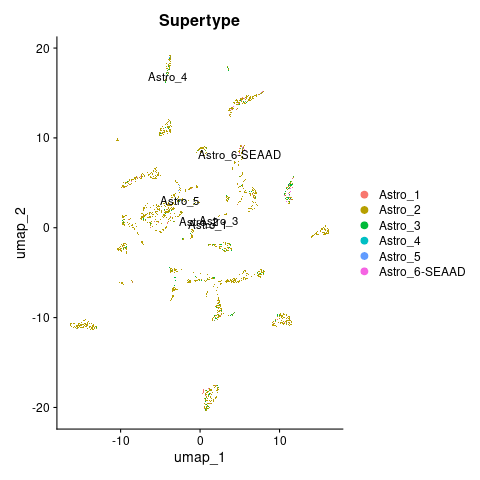

In [61]:
%%R

# Compute the UMAP coordinates for visualization
adata <- adata %>%
        FindVariableFeatures() %>%
        ScaleData() %>%
        RunPCA() %>%
        FindNeighbors() %>%
        RunUMAP(dims = 1:20)
        
# plot the cell annotation
DimPlot(adata,
        group.by = "Supertype",
        label = T,
        raster = T)

array([0., 0., 0., ..., 0., 0., 0.])

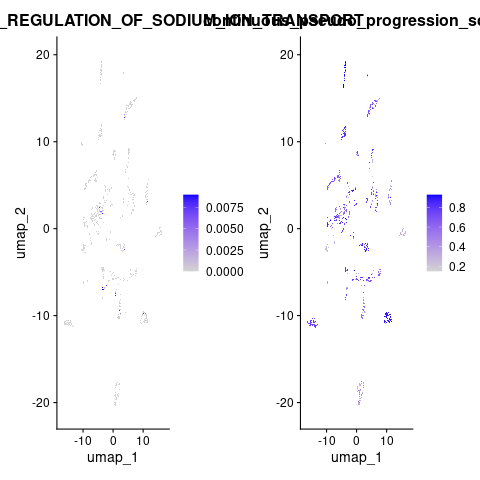

In [69]:
%%R

# add the label propagation probability and binarized label to meta data
adata@meta.data$GOBP_NEGATIVE_REGULATION_OF_SODIUM_ION_TRANSPORT <- cv[colnames(adata)]
adata@meta.data$GOBP_NEGATIVE_REGULATION_OF_SODIUM_ION_TRANSPORT_bin <- cl[colnames(adata)]

# plot the probabilities
FeaturePlot(adata,
        features = c("GOBP_NEGATIVE_REGULATION_OF_SODIUM_ION_TRANSPORT", 'continuous_pseudo_progression_score'),
        raster = T)